# Notebook for analyzing errors

In [2]:
import cv2
import numpy as np

import json


ROOT_FOLDER = "/datagrid/personal/baljibil"
# ground truth
with open(ROOT_FOLDER + '/data/MPII_COCO/annotations/mpii_val.json', 'r') as f:
    annot_truth = json.load(f)
# prediction
with open(ROOT_FOLDER + '/repos/scripts/coco_pred_on_mpii/pred.json', 'r') as f:
    annot_pred_coco = json.load(f)

with open(ROOT_FOLDER + '/repos/scripts/mpii_pred_on_mpii/pred.json', 'r') as f:
    annot_pred_mpii = json.load(f)


In [2]:
len_truth = len(annot_truth)
print(len_truth)

2958


In [3]:
def distance(p1, p2, metrics='euclidian'):
  # euclidian distance
  # remove when ground truth is empty
  # p1_filtered = p1[ p1[:,0] != -1 ]
  # p2_filtered = p2[ p1[:,0] != -1 ]
  if metrics=='euclidian':
    return np.linalg.norm(np.array(p1) - np.array(p2), axis=1)


In [43]:
# MPII -> COCO map
mapping_names = ['right_ankle', 'right_knee', 'left_ankle', 'left_knee', 'right_hip', 'left_hip', 'left_wrist',
                 'left_elbow', 'left_shoulder', 'right_wrist', 'right_elbow', 'right_shoulder']
mapping =  {0:16, 1:14, 5: 15, 4: 13, 2:12, 3:11, 15: 9, 14:7, 13: 5, 10:10, 11:8, 12:6}

kps_truth_joint_vis = list()
kps_truth = list()
box_scale = list()
kps_pred = list()
kps_ids = list()
for i in range(len(annot_truth)):
  
  kp_truth = annot_truth[i]['joints']
  kp_pred = annot_pred_coco['annotations'][i]['joints']

  # do left ankle
  kps_truth_joint_vis.append(annot_truth[i]['joints_vis'])
  kps_truth.append(kp_truth)
  kps_pred.append(kp_pred)
  kps_ids.append((i, annot_truth[i]['image']))
  box_scale.append(annot_truth[i]['scale'])
kps_truth = np.array(kps_truth)
kps_pred = np.array(kps_pred)
box_scale = np.array(box_scale)
kps_truth_joint_vis = np.array(kps_truth_joint_vis)


print("kps_truth: ", kps_truth.shape)
print("kps_pred: ", kps_pred.shape)
print("box_scale:", box_scale.shape)
  

kps_truth:  (2958, 16, 2)
kps_pred:  (2958, 17, 2)
box_scale: (2958,)


In [5]:
import matplotlib.pyplot as plt

Testing

In [44]:
errors = distance(kps_truth[:, 0], kps_pred[:, mapping[0]])
print(errors[:10])
def calculate_error(p1,p2):
  euc_distance = distance(p1, p2)
  print(euc_distance.shape)

[  25.36902371    5.09160978 1252.81729702 1066.16538871    3.38228783
   10.67824572   26.75929677   30.76375478    4.15014724    2.00510484]


In [45]:

errors = []
# TODO: resolve joint missing
for key in mapping.keys():
    gts = kps_truth[:, key]
    predictions = kps_pred[:, mapping[key]]
    gts = gts[ kps_truth_joint_vis[:, key] == 1 ]
    predictions = predictions [ kps_truth_joint_vis[:, key] == 1 ]
    
    error = distance(gts, predictions) / box_scale[kps_truth_joint_vis[:, key] == 1 ]
    errors.append(error)
coco_pred_on_mpii_errors = errors


## Euclidian distance MPII Annot vs COCO Prediction

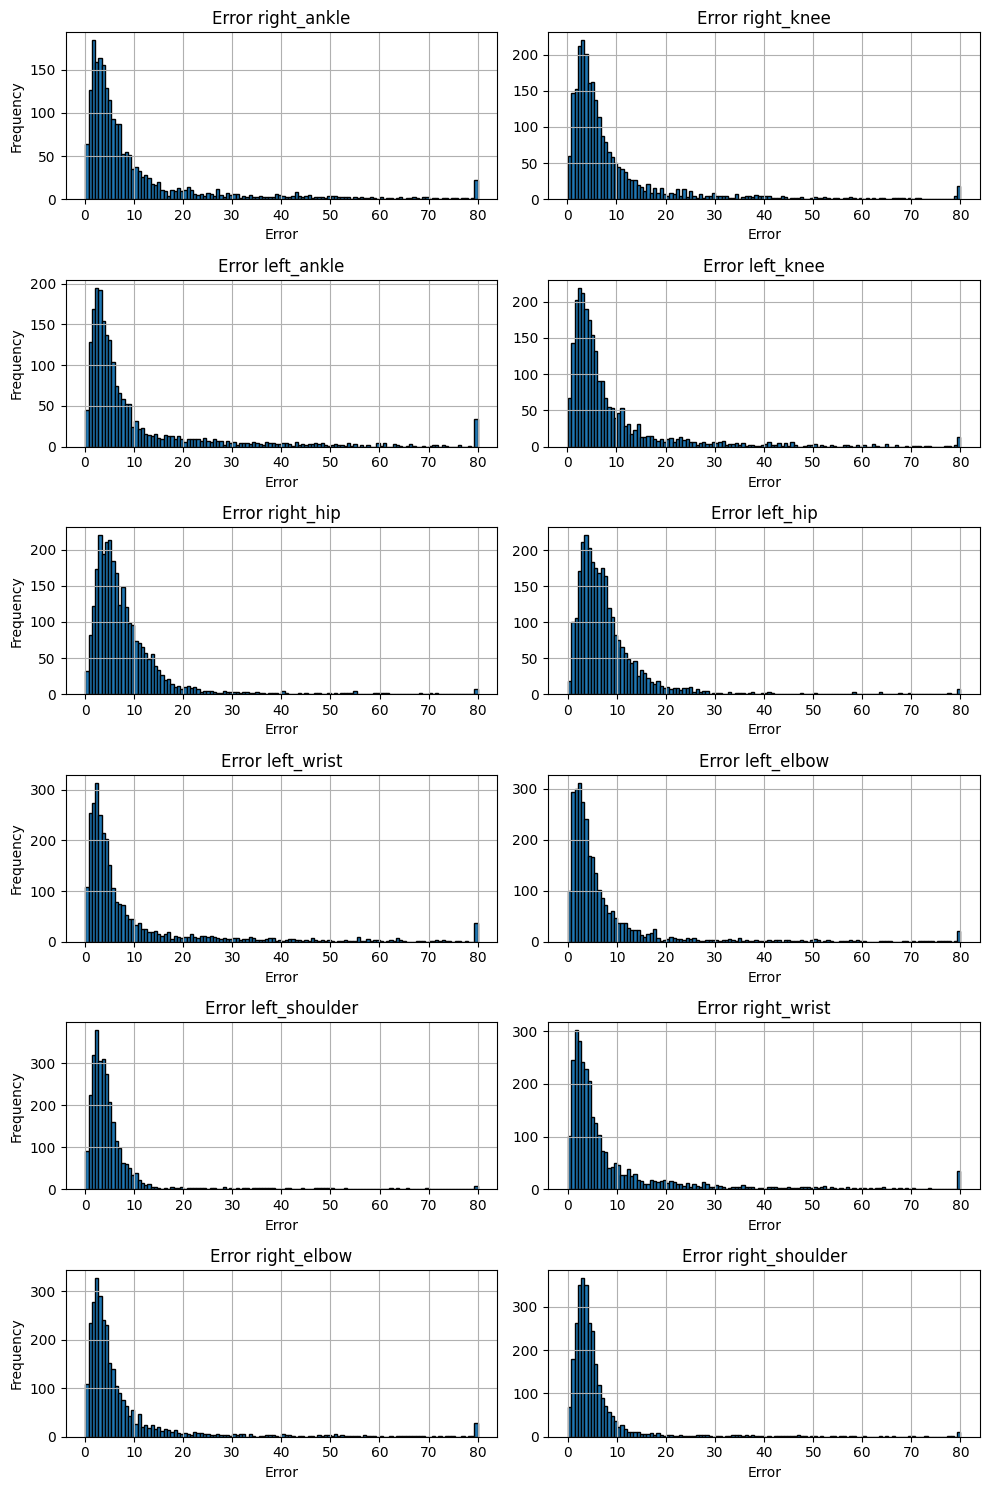

In [46]:
# left leg error

# Generate some example errors (replace this with your actual errors)
# errors = np.clip(0,100)
# Plot the histogram of errors
fig, axs = plt.subplots(nrows=(len(errors)+1)//2, ncols=2, figsize=(10,15))
for i in range(len(errors)):
  row = i // 2
  col = i % 2
  axs[row,col].hist(np.clip(errors[i], 0, 80), bins=120, edgecolor='black')
  axs[row,col].set_title(f'Error {mapping_names[i]}')
  axs[row,col].set_xlabel('Error')
  axs[row,0].set_ylabel('Frequency')
  axs[row,col].grid(True)
plt.tight_layout()
plt.show()

# TODO: normalize depending on image by the bounding box

### Check if there's any pattern in terms of y2-y1 x2-x1

In [47]:
errors = list()
for key in mapping.keys():
  errors.append(np.stack((kps_truth[:, key, 0] - kps_pred[:, mapping[key], 0] / box_scale, kps_truth[:, key, 1] - kps_pred[:, mapping[key], 1] / box_scale), axis=0))
print(errors[0].shape)
print(errors[:10])

(2, 2958)
[array([[ 629.06090976,  136.69905101, -328.96929106, ...,  374.33430736,
         429.15811192,  -37.90080679],
       [ 563.18757113,  175.28737709, -227.60663694, ...,  190.96049747,
         490.49150278,  -19.19187553]]), array([[643.19712625, 139.69386118, 705.91348516, ..., 395.48902247,
        427.16891725, -39.09345788],
       [399.47433201, 125.93429975, 451.61377304, ..., 142.98127573,
        381.15549092, -19.57071314]]), array([[ 691.47410304,  171.67888864, -308.79545137, ...,  420.95907524,
         508.33944527,  -31.15072243],
       [ 564.22471443,  175.73705245, -229.89893093, ...,  189.23933008,
         506.02966449,  -20.53620389]]), array([[719.1376484 , 176.12382613, 652.90318683, ..., 410.35241902,
        502.49215102, -29.70858611],
       [416.03041389, 128.34939814, 448.37131821, ..., 141.83202973,
        393.28519624, -15.8950085 ]]), array([[714.68685563, 120.6811423 , 736.86833042, ..., 397.70672079,
        433.1184054 , -22.19344752],
   

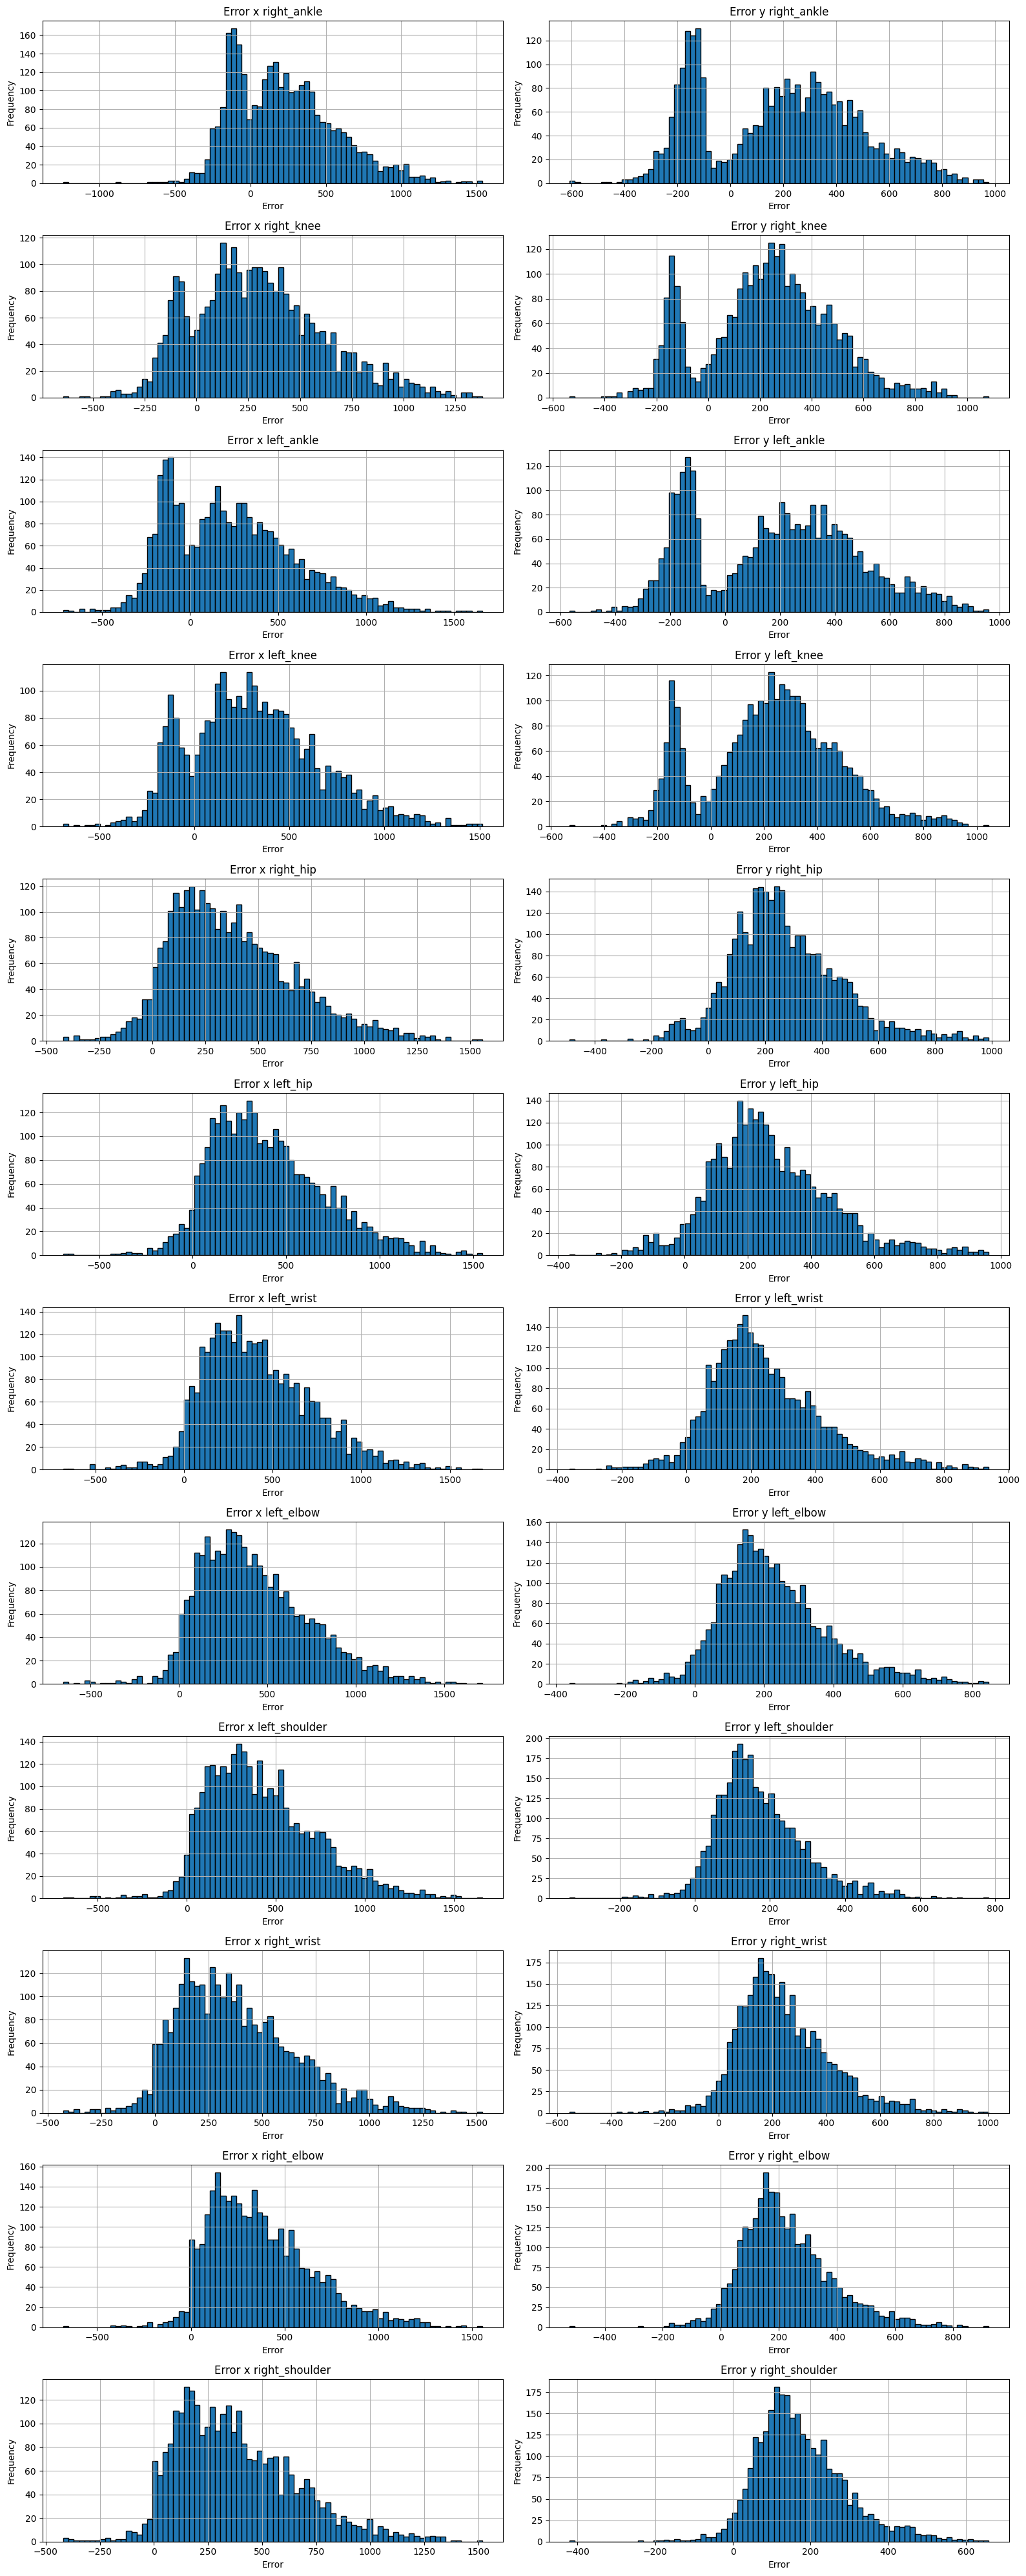

In [48]:

fig, axs = plt.subplots(nrows=(len(errors)), ncols=2, figsize=(16,40))
for i in range(len(errors)):
  row = i
  axs[row,0].hist(errors[i][0], bins=80, edgecolor='black')
  axs[row,0].set_title(f'Error x {mapping_names[i]}')
  axs[row,0].set_xlabel('Error')
  axs[row,0].set_ylabel('Frequency')
  axs[row,0].grid(True)

  axs[row,1].hist(errors[i][1], bins=80, edgecolor='black')
  axs[row,1].set_title(f'Error y {mapping_names[i]}')
  axs[row,1].set_xlabel('Error')
  axs[row,1].set_ylabel('Frequency')
  axs[row,1].grid(True)
plt.tight_layout()
plt.show()

## Evaluate with OKS(Object Keypoints Similarity) for AP

$$ OKS = \Sigma_{i} [exp(\frac{-d_{i}^{2}}{2s^{2}k_{i}^2}) \delta(v_{i}>0)] / \Sigma_{i} [\delta(v_{i}>0)]  $$
- where $d_{i}$ is euclidian distance for $i^{th}$ point
- where $s$ is the object scale and $k_{i}$ is a per-keypont constant that controls falloff
- where $v_{i}$ is visibility flag for $i^{th}$ keypoint

## Check if pelvis is just the average left and right hip

In [49]:
keypoint_info={
        0:
        dict(
            name='right_ankle',
            id=0,
            color=[255, 128, 0],
            type='lower',
            swap='left_ankle'),
        1:
        dict(
            name='right_knee',
            id=1,
            color=[255, 128, 0],
            type='lower',
            swap='left_knee'),
        2:
        dict(
            name='right_hip',
            id=2,
            color=[255, 128, 0],
            type='lower',
            swap='left_hip'),
        3:
        dict(
            name='left_hip',
            id=3,
            color=[0, 255, 0],
            type='lower',
            swap='right_hip'),
        4:
        dict(
            name='left_knee',
            id=4,
            color=[0, 255, 0],
            type='lower',
            swap='right_knee'),
        5:
        dict(
            name='left_ankle',
            id=5,
            color=[0, 255, 0],
            type='lower',
            swap='right_ankle'),
        6:
        dict(name='pelvis', id=6, color=[51, 153, 255], type='lower', swap=''),
        7:
        dict(name='thorax', id=7, color=[51, 153, 255], type='upper', swap=''),
        8:
        dict(
            name='upper_neck',
            id=8,
            color=[51, 153, 255],
            type='upper',
            swap=''),
        9:
        dict(
            name='head_top', id=9, color=[51, 153, 255], type='upper',
            swap=''),
        10:
        dict(
            name='right_wrist',
            id=10,
            color=[255, 128, 0],
            type='upper',
            swap='left_wrist'),
        11:
        dict(
            name='right_elbow',
            id=11,
            color=[255, 128, 0],
            type='upper',
            swap='left_elbow'),
        12:
        dict(
            name='right_shoulder',
            id=12,
            color=[255, 128, 0],
            type='upper',
            swap='left_shoulder'),
        13:
        dict(
            name='left_shoulder',
            id=13,
            color=[0, 255, 0],
            type='upper',
            swap='right_shoulder'),
        14:
        dict(
            name='left_elbow',
            id=14,
            color=[0, 255, 0],
            type='upper',
            swap='right_elbow'),
        15:
        dict(
            name='left_wrist',
            id=15,
            color=[0, 255, 0],
            type='upper',
            swap='right_wrist')
    },


In [50]:
kps_name2index = {keypoint_info[0][key]['name']:key for key in keypoint_info[0].keys() }
kps_index2name = {key:keypoint_info[0][key]['name'] for key in keypoint_info[0].keys() }

print(kps_name2index)
print(kps_index2name)

{'right_ankle': 0, 'right_knee': 1, 'right_hip': 2, 'left_hip': 3, 'left_knee': 4, 'left_ankle': 5, 'pelvis': 6, 'thorax': 7, 'upper_neck': 8, 'head_top': 9, 'right_wrist': 10, 'right_elbow': 11, 'right_shoulder': 12, 'left_shoulder': 13, 'left_elbow': 14, 'left_wrist': 15}
{0: 'right_ankle', 1: 'right_knee', 2: 'right_hip', 3: 'left_hip', 4: 'left_knee', 5: 'left_ankle', 6: 'pelvis', 7: 'thorax', 8: 'upper_neck', 9: 'head_top', 10: 'right_wrist', 11: 'right_elbow', 12: 'right_shoulder', 13: 'left_shoulder', 14: 'left_elbow', 15: 'left_wrist'}


In [51]:
print(kps_truth.shape)
# ground truth pelvis
pelvis_gt = kps_truth[:, kps_name2index['pelvis']]

# calculate pelvis
pelvis_pred = (kps_truth[:, kps_name2index['left_hip']] + kps_truth[:, kps_name2index['right_hip']]) / 2 
print(pelvis_gt[:5])
print(pelvis_pred[:5])
pelvis_gt = pelvis_gt[ kps_truth_joint_vis[:,kps_name2index['pelvis']] == 1 ]
pelvis_pred = pelvis_pred[ kps_truth_joint_vis[:,kps_name2index['pelvis']] == 1 ]


errors = distance(pelvis_pred, pelvis_gt) / box_scale[ kps_truth_joint_vis[:,kps_name2index['pelvis']] == 1 ]
print(errors.shape)


print("Min: ", errors.min())
print("Max: ", errors.max())
print("Mean: ", np.mean(errors))
print("Median: ", np.median(errors))
print("25%: ", np.percentile(errors, 25))
print("75%: ", np.percentile(errors, 75))


(2958, 16, 2)
[[ 974.  446.]
 [ 322.  275.]
 [1023.  485.]
 [ 827.  504.]
 [ 709.  429.]]
[[ 974.   446. ]
 [ 321.5  274.5]
 [1022.5  485. ]
 [ 827.   503.5]
 [ 708.5  429. ]]
(2878,)
Min:  0.0
Max:  354.8547302487549
Mean:  0.32673858988358867
Median:  0.15167070530997076
25%:  0.0
75%:  0.2603709224633721


## Display outliers

In [56]:
kps_ids_np = np.array(kps_ids)
kps_ids_np = kps_ids_np[ kps_truth_joint_vis[:,kps_name2index['pelvis']] == 1 ]
outliers_images = []
for i, err in enumerate(errors):
  if err > 10:
    print(err, i, kps_ids_np[i][0])
    outliers_images.append((int(kps_ids_np[i][0]), kps_ids_np[i][1]))
print(outliers_images)

40.09639279546216 241 247
354.8547302487549 509 518
36.5188754497426 659 672
[(247, '094172571.jpg'), (518, '008975950.jpg'), (672, '064421302.jpg')]


In [54]:
import cv2
import json
from IPython.display import Image, display


In [55]:

ROOT_FOLDER = "/datagrid/personal/baljibil"
# ground truth
with open(ROOT_FOLDER + '/data/MPII_COCO/annotations/mpii_val.json', 'r') as f:
    annot_truth = json.load(f)
# prediction
with open(ROOT_FOLDER + '/repos/scripts/mpii_pred_on_mpii/pred.json', 'r') as f:
    annot_pred = json.load(f)

for i, im in outliers_images:
  # Load the image
  print(i, im)
  image = cv2.imread(ROOT_FOLDER + '/data/MPII_COCO/images/' + im)

  # Load annotation keypoints from JSON files

  keypoints1 = annot_truth[i]['joints']
  keypoints2 = annot_pred['annotations'][i]['joints']
  print(keypoints1, keypoints2)
  # Draw keypoints on the image
  for kp in keypoints1:
      x, y = int(kp[0]), int(kp[1])
      cv2.circle(image, (x, y), 3, (0, 255, 0), -1)

  for kp in keypoints2:
      x, y = int(kp[0]), int(kp[1])
      cv2.circle(image, (x, y), 3, (0, 0, 255), -1)

  # Resize the image if necessary
  # This step is optional, depending on your images

  # Split the image horizontally
#   image1 = image[:, :image.shape[1]//2]
#   image2 = image[:, image.shape[1]//2:]

  # Display the annotated images side by side
  cv2.imwrite(f'results/image{i}.jpg', image)

  display(Image(filename=f'results/image{i}.jpg'))


247 094172571.jpg


TypeError: list indices must be integers or slices, not numpy.str_

Results are in results folder


In [ ]:
kps_pred = list()
for i in range(len(annot_truth)):
  
  kp_pred = annot_pred_mpii['annotations'][i]['joints']
  kps_pred.append(kp_pred)
kps_pred = np.array(kps_pred)

mpii_pred_on_mpii_errors = []
# TODO: resolve joint missing
for key in mapping.keys():
    gts = kps_truth[:, key]
    predictions = kps_pred[:, key]
    
    gts = gts[kps_truth_joint_vis[:,key] == 1]
    predictions = predictions[ kps_truth_joint_vis[:,key] == 1 ]

    error = distance(gts, predictions) / box_scale[ kps_truth_joint_vis[:,key] == 1  ]
    mpii_pred_on_mpii_errors.append(error)


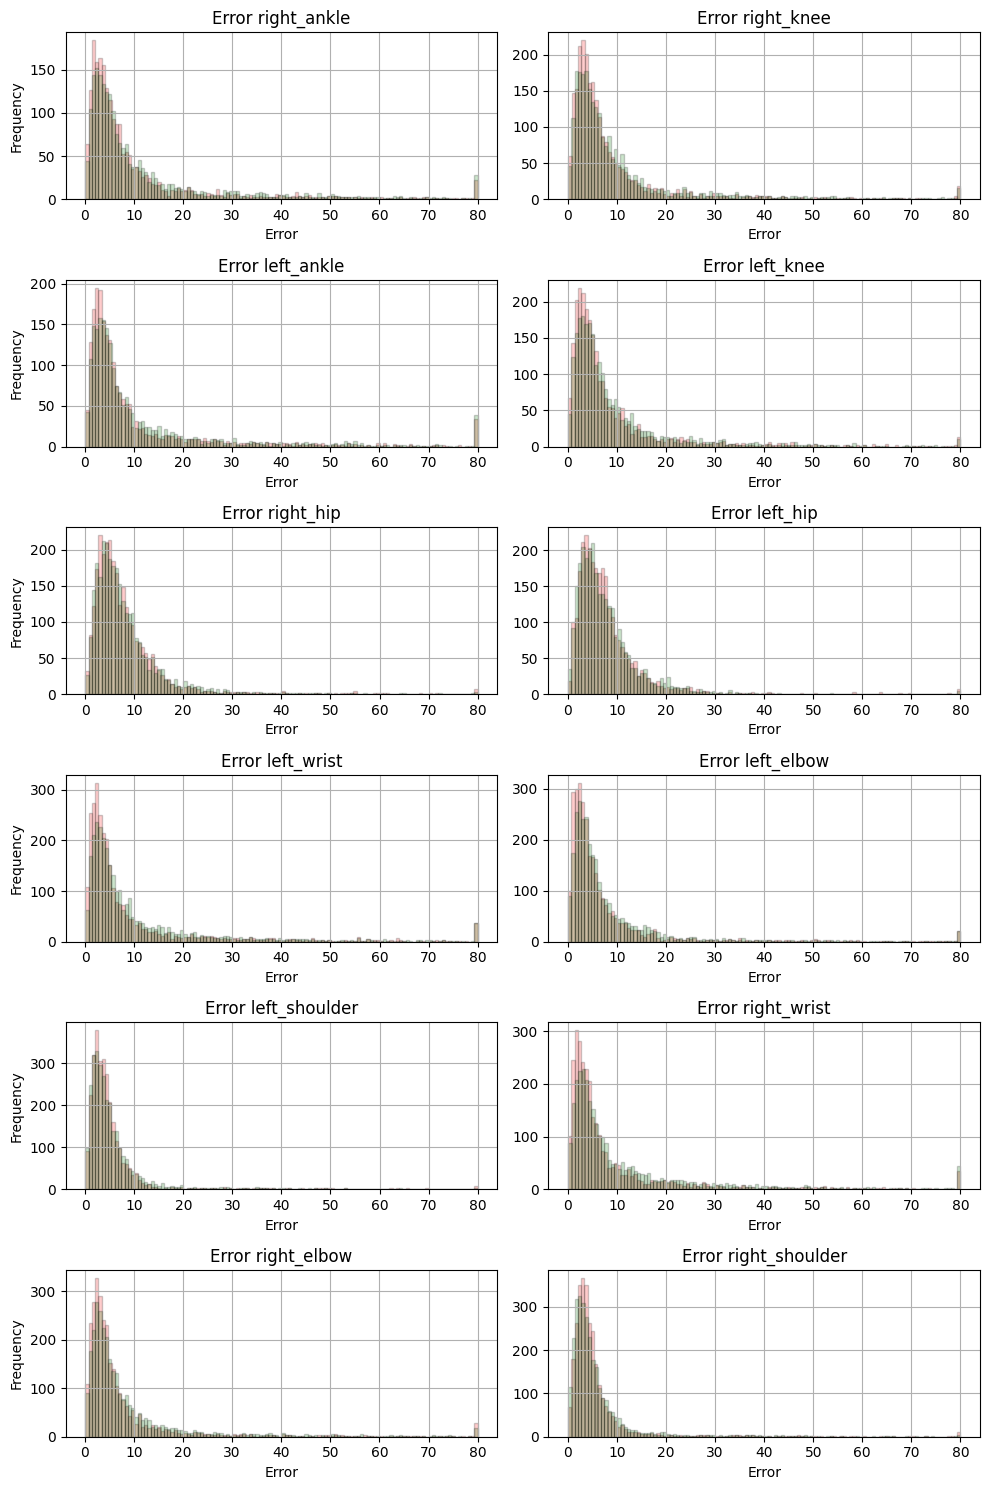

In [ ]:
fig, axs = plt.subplots(nrows=(len(mpii_pred_on_mpii_errors)+1)//2, ncols=2, figsize=(10,15))
for i in range(len(mpii_pred_on_mpii_errors)):
  row = i // 2
  col = i % 2
  axs[row,col].hist(np.clip(coco_pred_on_mpii_errors[i], 0, 80), bins=120, edgecolor='black', alpha=0.2, color='red')
  axs[row,col].hist(np.clip(mpii_pred_on_mpii_errors[i], 0, 80), bins=120, edgecolor='black', alpha=0.2, color='green')

  axs[row,col].set_title(f'Error {mapping_names[i]}')
  axs[row,col].set_xlabel('Error')
  axs[row,0].set_ylabel('Frequency')
  axs[row,col].grid(True)
plt.tight_layout()
plt.show()

### absolute error between mpii vs coco predictions on mpii dataset

In [ ]:

kps_pred_coco = list()
kps_pred_mpii = list()
for i in range(len(annot_truth)):
  kps_pred_mpii.append(annot_pred_mpii['annotations'][i]['joints'])
  kps_pred_coco.append(annot_pred_coco['annotations'][i]['joints'])
kps_pred_mpii = np.array(kps_pred_mpii)
kps_pred_coco = np.array(kps_pred_coco)

kps_pred = np.array(kps_pred)
print("MPII PRED VS COCO PRED")
for key in mapping.keys():
    predictions_mpii = kps_pred_mpii[:, key]
    predictions_coco = kps_pred_coco[:, mapping[key]]

    predictions_mpii = predictions_mpii [kps_truth_joint_vis[:,key] == 1]
    predictions_coco = predictions_coco [kps_truth_joint_vis[:,key] == 1]

    error = distance(predictions_mpii, predictions_coco) / box_scale[kps_truth_joint_vis[:,key] == 1]
    print(f'{kps_index2name[key]} has error mean: {np.mean(error)}')

print("MPII PRED VS MPII GT")
for key in mapping.keys():
    gts = kps_truth[:, key]
    predictions_mpii = kps_pred_mpii[:, key]

    gts = gts [kps_truth_joint_vis[:,key] == 1]
    predictions_mpii = predictions_mpii [kps_truth_joint_vis[:,key] == 1]

    error = distance(predictions_mpii, gts) / box_scale[ kps_truth_joint_vis[:,key] == 1 ]
    print(f'{kps_index2name[key]} has error mean: {np.mean(error)}')

print("COCO PRED VS MPII GT")
for key in mapping.keys():
    gts = kps_truth[:, key]
    predictions_coco = kps_pred_coco[:, mapping[key]]

    gts = gts [kps_truth_joint_vis[:,key] == 1]
    predictions_coco = predictions_coco [kps_truth_joint_vis[:,key] == 1]

    error = distance(predictions_coco, gts) / box_scale [kps_truth_joint_vis[:,key] == 1 ]
    print(f'{kps_index2name[key]} has error mean: {np.mean(error)}')

MPII PRED VS COCO PRED
right_ankle has error mean: 12.049154337226266
right_knee has error mean: 9.856402344000013
left_ankle has error mean: 11.939664262398747
left_knee has error mean: 9.587539851546708
right_hip has error mean: 7.601833406319403
left_hip has error mean: 7.559061735386985
left_wrist has error mean: 10.944267962591876
left_elbow has error mean: 8.107346230143524
left_shoulder has error mean: 5.539823891552782
right_wrist has error mean: 10.867290501584918
right_elbow has error mean: 8.60164269460355
right_shoulder has error mean: 5.6907398989374665
MPII PRED VS MPII GT
right_ankle has error mean: 12.62537299369046
right_knee has error mean: 10.526737026619173
left_ankle has error mean: 12.77060714659583
left_knee has error mean: 10.187787262865864
right_hip has error mean: 8.271872291427186
left_hip has error mean: 8.17557394255949
left_wrist has error mean: 11.52756714869582
left_elbow has error mean: 8.758503243860234
left_shoulder has error mean: 6.0498786903499004